# Public contracting in Colombia

Juan Camilo Azuero

The purpose of this project is to diagnose public contracting in Colombia, identify unusual contracting patterns that generate suspicion of fraud, and understand what factors are related to a successful contracting process. This project is a requirement of the course "Data Mining Prject" from the University of Colorado Boulder<br>
This exploration is built on a public procurement dataset available in the <a href="https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Contratos-Electr-nicos/jbjy-vk9h">Colombian government's open data platform</a>

## Imports and setup

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sodapy import Socrata
import datetime

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import col, when, lit, udf
from secop.pipelines.data_engineering.utilities import (
    _get_nits_to_extract,
    _remove_tildes,
    _clean_modalidad_contratacion,
    _clean_modalidad_contratacion_2,
    _clean_tipo_contrato,
    _to_int,
    _clean_tipodocproveecor,
)
from secop.pipelines.data_engineering.utilities import _remove_tildes
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import re
import itertools
import warnings
import seaborn as sns

[08/13/22 11:00:31] WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=918249;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=431881;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils                       
                             Version classes are deprecated. Use packaging.version instead.                        
                               if LooseVersion(mpl.__version__) >= "3.0":                                          
                                                                                                                   

                    WARNING  /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/s ]8;id=138900;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py\warnings.py]8;;\:]8;id=597074;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/warnings.py#109\109]8;;\
                             ite-packages/setuptools/_distutils/version.py:346: DeprecationWarning:                
                             distutils Version classes are deprecated. Use packaging.version                       
                             instead.                                                                              
                               other = LooseVersion(other)                                                         
                                                                                                                   

In [2]:
warnings.filterwarnings("ignore")

In [3]:
def prop_counts(ser: pd.Series):
    vc = ser.value_counts()
    res = vc / vc.sum()
    return (res * 100).apply(lambda x: str(int(x)) + "%")

In [4]:
%load_ext nb_black
%matplotlib inline

<IPython.core.display.Javascript object>

## EDA

In [5]:
secop_2 = catalog.load("secop_2_cont@pandas")

[08/13/22 11:00:35] INFO     Loading data from 'secop_2_cont@pandas' (ParquetDataSetSecop)...   ]8;id=452396;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=429884;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

Columns with nans

In [6]:
sisna = secop_2.isna().mean()
sisna[sisna > 0]

fecha_de_firma                  0.071460
fecha_de_inicio_del_contrato    0.077660
fecha_de_fin_del_contrato       0.014146
dtype: float64

<IPython.core.display.Javascript object>

Process text of categorical columns

In [7]:
COLS_TILDES_LOWER = [
    "nombre_entidad",
    "departamento",
    "ciudad",
    "orden",
    "estado_contrato",
    "modalidad_de_contratacion",
    "tipodocproveedor",
    "proveedor_adjudicado",
]
secop_2[COLS_TILDES_LOWER] = (
    secop_2[COLS_TILDES_LOWER].applymap(lambda x: _remove_tildes(x.lower())).values
)
# And only to lower case for not categorical
secop_2["descripcion_del_proceso"] = secop_2["descripcion_del_proceso"].apply(str.lower)
secop_2["objeto_del_contrato"] = secop_2["objeto_del_contrato"].apply(str.lower)

<IPython.core.display.Javascript object>

In [8]:
secop_2["modalidad_de_contratacion"] = secop_2["modalidad_de_contratacion"].apply(
    _clean_modalidad_contratacion_2
)

<IPython.core.display.Javascript object>

Most contracts are through direct hiring. This is not a recomended practice, and is only allowed on exceptional cases. <a href="http://www.secretariasenado.gov.co/senado/basedoc/ley_1150_2007.html">Reference in spanish.</a>

In [9]:
prop_counts(secop_2["modalidad_de_contratacion"])

contratacion directa    77%
regimen especial        11%
menor cuantia            8%
subasta                  1%
licitacion publica       0%
concurso meritos         0%
otro                     0%
Name: modalidad_de_contratacion, dtype: object

<IPython.core.display.Javascript object>

In [10]:
secop_2["estado_contrato"].value_counts()

en ejecucion         668280
modificado           457551
activo               232137
terminado            203882
cerrado              101951
borrador              92320
enviado proveedor     23094
cedido                16259
en aprobacion         14764
suspendido             2740
prorrogado              146
Name: estado_contrato, dtype: int64

<IPython.core.display.Javascript object>

In [11]:
secop_2[secop_2["fecha_de_firma"].isna()]["estado_contrato"].value_counts()

borrador             91894
enviado proveedor    22975
en aprobacion        14679
modificado               9
activo                   7
cerrado                  1
terminado                1
Name: estado_contrato, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
secop_2.dropna(subset=["fecha_de_firma", "fecha_de_fin_del_contrato"], inplace=True)

<IPython.core.display.Javascript object>

In [13]:
prop_counts(secop_2["estado_contrato"])

en ejecucion         39%
modificado           27%
activo               13%
terminado            12%
cerrado               6%
cedido                0%
suspendido            0%
borrador              0%
prorrogado            0%
enviado proveedor     0%
en aprobacion         0%
Name: estado_contrato, dtype: object

<IPython.core.display.Javascript object>

In [14]:
sisna = secop_2.isna().mean()
sisna[sisna > 0]

fecha_de_inicio_del_contrato    0.025207
dtype: float64

<IPython.core.display.Javascript object>

In [16]:
secop_2["nit_entidad"] = (
    secop_2["nit_entidad"]
    .astype(int)
    .apply(lambda x: int(np.floor(x / 10)) if x >= 1000000000 else x)
)

<IPython.core.display.Javascript object>

In [17]:
for c in ["dias_adicionados", "valor_del_contrato", "documento_proveedor"]:
    secop_2[c] = secop_2[c].apply(_to_int)

<IPython.core.display.Javascript object>

In [18]:
secop_2["year_fecha_de_firma"] = pd.DatetimeIndex(secop_2["fecha_de_firma"]).year
secop_2["month_fecha_de_firma"] = pd.DatetimeIndex(secop_2["fecha_de_firma"]).month

<IPython.core.display.Javascript object>

In [19]:
secop_2 = secop_2[
    ~secop_2["descripcion_del_proceso"].apply(
        lambda x: x[:29] == "convenio interadministrativo"
    )
].copy()
secop_2["tipodocproveedor"] = secop_2["tipodocproveedor"].apply(_clean_tipodocproveecor)
secop_2 = secop_2[secop_2["valor_del_contrato"] > 0].copy()

<IPython.core.display.Javascript object>

In [20]:
len(secop_2)

1667872

<IPython.core.display.Javascript object>

In [21]:
secop_2 = secop_2[secop_2["nombre_entidad"] != "viviana bravo rivas"].copy()
secop_2 = secop_2[
    ~secop_2["proveedor_adjudicado"].isin(secop_2["nombre_entidad"].unique())
].copy()

<IPython.core.display.Javascript object>

Most 

In [22]:
prop_counts(secop_2["tipodocproveedor"])

cedula de ciudadania    83%
nit                     15%
Otro                     0%
Name: tipodocproveedor, dtype: object

<IPython.core.display.Javascript object>

[<matplotlib.lines.Line2D object at 0x29d6557b0>]

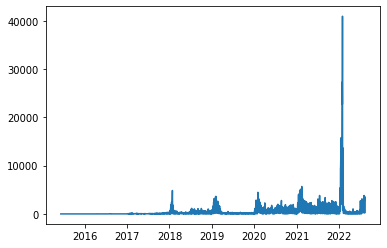

<IPython.core.display.Javascript object>

In [23]:
plt.plot(
    secop_2[["fecha_de_firma", "referencia_del_contrato"]]
    .groupby("fecha_de_firma")
    .count()
)

In [24]:
secop_2["year_month_fecha_de_firma"] = secop_2.apply(
    lambda row: datetime.date( row["year_fecha_de_firma"],row["month_fecha_de_firma"],1),
    axis=1,
)


<IPython.core.display.Javascript object>

[<matplotlib.lines.Line2D object at 0x359906290>]

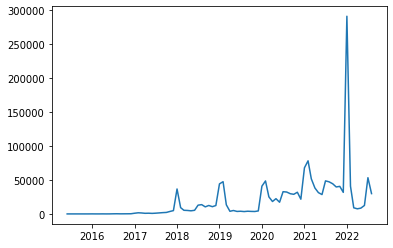

<IPython.core.display.Javascript object>

In [25]:
plt.plot(
    secop_2[["year_month_fecha_de_firma", "referencia_del_contrato"]]
    .groupby("year_month_fecha_de_firma")
    .count()
)

In [26]:
secop_2["dlrs_contrato"] = secop_2["valor_del_contrato"].apply(
    lambda x: "${:0,.1f}".format(x / 4000)
)

<IPython.core.display.Javascript object>

[<matplotlib.lines.Line2D object at 0x2e11a6080>]

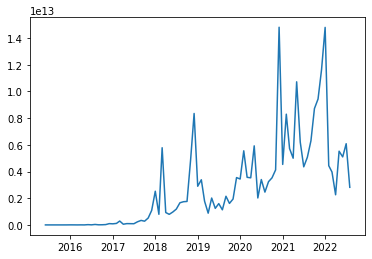

<IPython.core.display.Javascript object>

In [27]:
plt.plot(
    secop_2[["year_month_fecha_de_firma", "valor_del_contrato"]]
    .groupby("year_month_fecha_de_firma")
    .sum()
)

In [28]:
secop_2.describe()

,documento_proveedor,valor_del_contrato,dias_adicionados,nit_entidad,year_fecha_de_firma,month_fecha_de_firma
count,1.654401e+06,1.654401e+06,1.654401e+06,1.654401e+06,1.654401e+06,1.654401e+06
mean,5.462589e+11,1.483951e+08,1.047556e+01,8.750859e+08,2.020583e+03,4.839712e+00
std,6.686853e+14,4.991941e+09,3.501200e+01,4.723694e+07,1.280599e+00,3.697959e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,7.180873e+06,2.015000e+03,1.000000e+00
25%,5.215288e+07,1.040049e+07,0.000000e+00,8.900005e+08,2.020000e+03,1.000000e+00
50%,8.050254e+08,2.074598e+07,0.000000e+00,8.920001e+08,2.021000e+03,4.000000e+00
75%,1.033705e+09,3.990233e+07,0.000000e+00,8.999991e+08,2.022000e+03,8.000000e+00
max,8.600651e+17,3.482944e+12,3.836000e+03,9.015527e+08,2.022000e+03,1.200000e+01


<IPython.core.display.Javascript object>

In [29]:
secop_2.columns

Index(['nombre_entidad', 'departamento', 'ciudad', 'orden',
       'proceso_de_compra', 'referencia_del_contrato', 'estado_contrato',
       'descripcion_del_proceso', 'modalidad_de_contratacion',
       'fecha_de_firma', 'fecha_de_inicio_del_contrato',
       'fecha_de_fin_del_contrato', 'tipodocproveedor', 'documento_proveedor',
       'proveedor_adjudicado', 'valor_del_contrato', 'objeto_del_contrato',
       'dias_adicionados', 'nit_entidad', 'year_fecha_de_firma',
       'month_fecha_de_firma', 'year_month_fecha_de_firma', 'dlrs_contrato'],
      dtype='object')

<IPython.core.display.Javascript object>

In [30]:
secop_2[
    [
        "descripcion_del_proceso",
        "dlrs_contrato",
        "valor_del_contrato",
        "proveedor_adjudicado",
    ]
].sort_values("valor_del_contrato").tail(10).values

array([['onvenio de asociación para para la formulación del plan de manejo del distrito regional de manejo integrado  playona - loma caleta',
        '$219,000,000.0', 876000000000,
        'corporacion para el avance de la region pacifica y el darien colombiano'],
       ['realizar la operación  administración y recaudo de la tasa de peaje con recaudo electrónico (ip-rev) y recaudo manual con y sin equipos de control de tránsito en las estaciones de peaje  así como la operación y administración de las estaciones de pesaje  áreas administrativas y centros de control de',
        '$237,065,250.0', 948261000000,
        'union temporal peajes nacionales'],
       ['ejecutar el proyecto centros digitales en la región adjudicada obligándose a realizar la planeación  instalación  operación y mantenimiento de la infraestructura para prestar el servicio de internet bajo las condiciones establecidas en el anexo técnico.',
        '$266,391,242.2', 1065564968972, 'comcel s.a.'],
       ['ejecutar el proyecto centros digitales en la región adjudicada obligándose a realizar la planeación  instalación  operación y mantenimiento de la infraestructura para prestar el servicio de internet bajo las condiciones establecidas en el anexo técnico.',
        '$268,138,075.4', 1072552301475, 'ut etb net colombia conectada'],
       ['ejecutar el proyecto centros digitales en la región adjudicada obligándose a realizar la planeación  instalación  operación y mantenimiento de la infraestructura para prestar el servicio de internet bajo las condiciones establecidas en el anexo técnico.',
        '$268,138,075.4', 1072552301475,
        'union temporal centros poblados colombia 2020'],
       ['concesionar bajo la figura de áreas de servicio exclusivo  la prestación del servicio público de aseo en la ciudad de bogotá d.c. - colombia  en sus componentes de recolección de residuos no aprovechables  barrido  limpieza de vías y áreas públicas  corte de césped  poda de árboles en áreas públicas',
        '$270,475,000.0', 1081900000000,
        'promoambiental distrito s.a.s. esp'],
       ['producción de alimentos de alto valor nutricional  desarrollo de nuevos productos y distribución a puntos de entrega primarios',
        '$276,974,872.4', 1107899489590, 'ingredion colombia sa'],
       ['concesionar bajo la figura de áreas de servicio exclusivo  la prestación del servicio público de aseo en la ciudad de bogotá d.c. - colombia  en sus componentes de recolección de residuos no aprovechables  barrido  limpieza de vías y áreas públicas  corte de césped  poda de árboles en áreas públicas',
        '$375,950,000.0', 1503800000000,
        'limpieza metropolitana s a esp'],
       ['contratar una solución integral logística  tecnológica  informática y de servicios  para la organización y realización de los procesos electorales a llevarse a cabo en los años 2021 y 2022  de conformidad con los requerimientos y especificaciones descritos en el anexo técnico y demás documentos que',
        '$449,926,812.4', 1799707249746,
        'union temporal distribucion procesos electorales 2021'],
       ['servicios de mantenimiento programados  imprevistos  horas hombre y suministro de repuestos  partes  componentes y equipos para el sostenimiento de la flota airbus helicopters de la aviación naval',
        '$870,735,993.0', 3482943972000,
        'airbus helicopters mexico sa.de cv']], dtype=object)

<IPython.core.display.Javascript object>

In [31]:
len(secop_2)

1654401

<IPython.core.display.Javascript object>

(0.0, 1000000000.0)

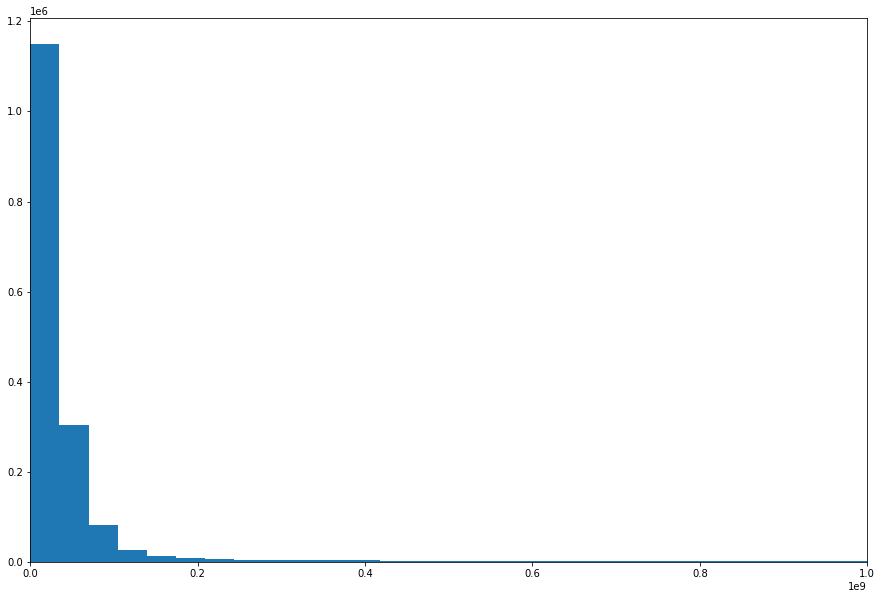

<IPython.core.display.Javascript object>

In [32]:
fig, ax = plt.subplots()
ax.hist(secop_2["valor_del_contrato"], bins=100000)
fig.set_size_inches(15, 10)
ax.set_xlim(0, 1000000000)

In [33]:
secop_2["log_valor_del_contrato"] = secop_2["valor_del_contrato"].apply(np.log)

<IPython.core.display.Javascript object>

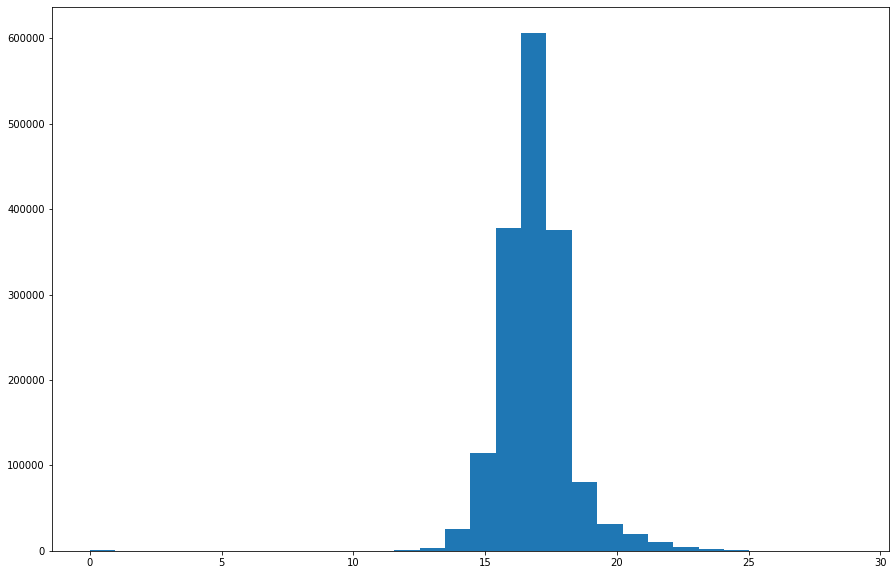

<IPython.core.display.Javascript object>

In [34]:
fig, ax = plt.subplots()
ax.hist(secop_2["log_valor_del_contrato"], bins=30)
fig.set_size_inches(15, 10)

### Text processing

In [35]:
stopwords = nltk.corpus.stopwords.words("spanish")
stopwords = ["".join([s for s in w if s not in string.punctuation]) for w in stopwords]


def text_preprocessing(sentence: str):
    sentence = re.sub(r"\n", " ", sentence)
    sentence = "".join([s for s in sentence if s not in string.punctuation])
    sentence = [w for w in sentence.split(" ") if w not in stopwords and w != ""]
    return sentence

<IPython.core.display.Javascript object>

In [36]:
secop_2.columns

Index(['nombre_entidad', 'departamento', 'ciudad', 'orden',
       'proceso_de_compra', 'referencia_del_contrato', 'estado_contrato',
       'descripcion_del_proceso', 'modalidad_de_contratacion',
       'fecha_de_firma', 'fecha_de_inicio_del_contrato',
       'fecha_de_fin_del_contrato', 'tipodocproveedor', 'documento_proveedor',
       'proveedor_adjudicado', 'valor_del_contrato', 'objeto_del_contrato',
       'dias_adicionados', 'nit_entidad', 'year_fecha_de_firma',
       'month_fecha_de_firma', 'year_month_fecha_de_firma', 'dlrs_contrato',
       'log_valor_del_contrato'],
      dtype='object')

<IPython.core.display.Javascript object>

In [37]:
secop_2["full_contract_description"] = (
    secop_2["descripcion_del_proceso"] + secop_2["objeto_del_contrato"]
)

<IPython.core.display.Javascript object>

In [38]:
secop_2["full_contract_description"] = secop_2["full_contract_description"].apply(
    text_preprocessing
)

<IPython.core.display.Javascript object>

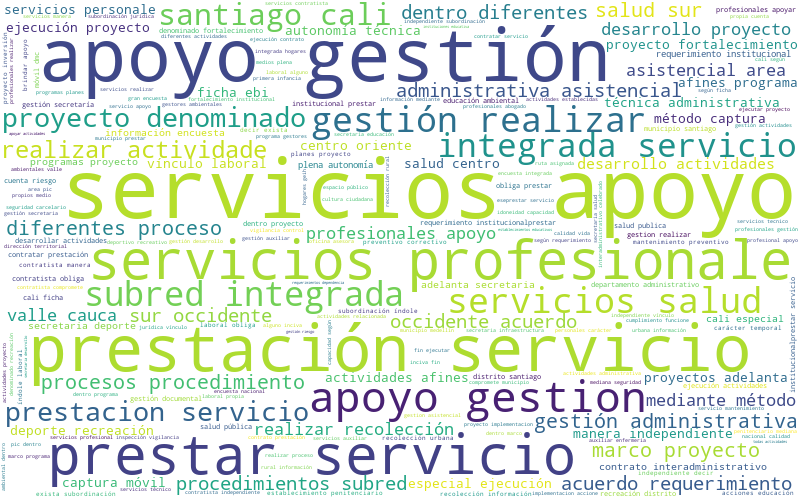

<IPython.core.display.Javascript object>

In [39]:
words = list(
    itertools.chain(
        *secop_2.sort_values("valor_del_contrato")
        .head(int(len(secop_2) * 0.2))["full_contract_description"]
        .values
    )
)
word_cloud = WordCloud(background_color="White", height=500, width=800)
wc = word_cloud.generate_from_text(" ".join(words))
wc.to_image()

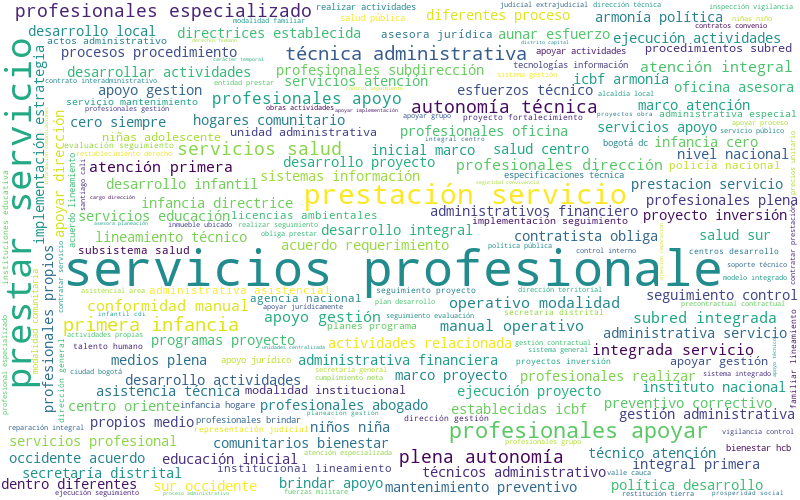

<IPython.core.display.Javascript object>

In [40]:
words = list(
    itertools.chain(
        *secop_2.sort_values("valor_del_contrato")
        .tail(int(len(secop_2) * 0.2))["full_contract_description"]
        .values
    )
)
word_cloud = WordCloud(background_color="White", height=500, width=800)
wc = word_cloud.generate_from_text(" ".join(words))
wc.to_image()

In [39]:
secop_2["duration_days"] = secop_2.apply(
    lambda row: max(0, (row["fecha_de_fin_del_contrato"] - row["fecha_de_firma"]).days)
    if pd.isna(row["fecha_de_inicio_del_contrato"])
    else (row["fecha_de_fin_del_contrato"] - row["fecha_de_inicio_del_contrato"]).days,
    axis=1,
)

<IPython.core.display.Javascript object>

In [40]:
secop_2 = secop_2[secop_2["duration_days"] >= 0].copy()

<IPython.core.display.Javascript object>

Se nota que una gran cantidad de contratos de contratación directa duran 1 año y 1 y medio. Eso se debe a que la prestación de servicios normalmente es contratada por el sector público por medio de contratación directa a termino de 6 meses o 1 año.

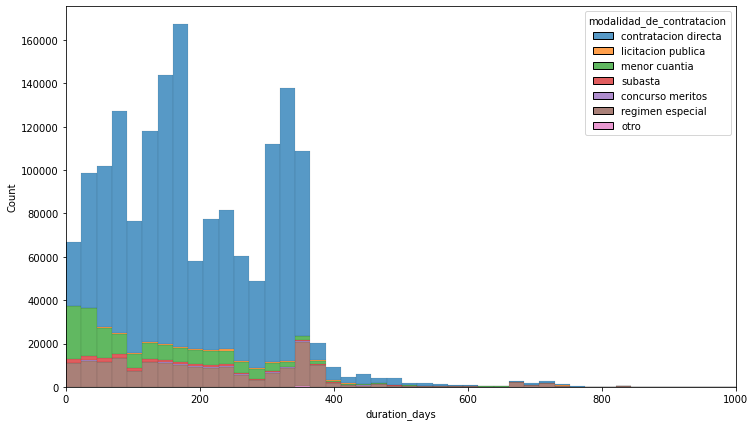

<IPython.core.display.Javascript object>

In [43]:
fig, ax = plt.subplots()
sns.histplot(
    data=secop_2,
    x="duration_days",
    bins=480,
    hue="modalidad_de_contratacion",
    # stat="probability",
    common_norm=False,
    ax=ax,
    multiple="stack",
)
ax.set_xlim(0, 1000)
fig.set_size_inches(12, 7)

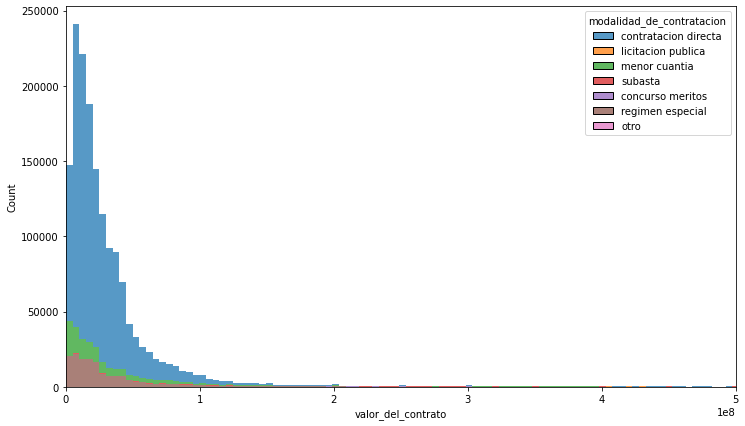

<IPython.core.display.Javascript object>

In [59]:
fig, ax = plt.subplots()
sns.histplot(
    data=secop_2,
    x="valor_del_contrato",
    bins=700000,
    hue="modalidad_de_contratacion",
    # stat="probability",
    common_norm=False,
    ax=ax,
    multiple="stack",
)
ax.set_xlim(0, 500000000)
fig.set_size_inches(12, 7)

In [60]:
(secop_2["dias_adicionados"] == 0).mean()

0.8424896047853953

<IPython.core.display.Javascript object>

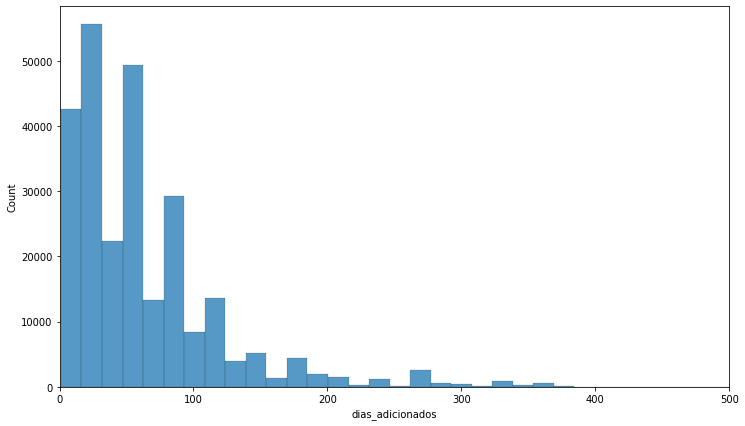

<IPython.core.display.Javascript object>

In [61]:
fig, ax = plt.subplots()
sns.histplot(
    data=secop_2[secop_2["dias_adicionados"] > 0],
    x="dias_adicionados",
    bins=250,
    # stat="probability",
    common_norm=False,
    ax=ax,
    multiple="stack",
)
ax.set_xlim(0, 500)
fig.set_size_inches(12, 7)

In [41]:
economia_departamentos = catalog.load("economia_departamentos")

[08/13/22 11:15:54] INFO     Loading data from 'economia_departamentos' (CSVDataSet)...         ]8;id=256704;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=156887;file:///opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

<IPython.core.display.Javascript object>

In [42]:
economia_departamentos["Departamento"] = economia_departamentos["Departamento"].apply(
    lambda x: _remove_tildes(x.lower())
)

<IPython.core.display.Javascript object>

In [43]:
economia_departamentos["Departamento"] = economia_departamentos["Departamento"].replace(
    {
        "san andres, providencia y santa catalina (archipielago)": "san andres, providencia y santa catalina",
        "bogota d.c.": "distrito capital de bogota",
    }
)

<IPython.core.display.Javascript object>

In [44]:
economia_departamentos.drop("Codigo", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [45]:
for c in economia_departamentos.columns:
    if c not in ["Departamento", "Poblacion"]:
        economia_departamentos[c] = (
            economia_departamentos[c] / economia_departamentos["Poblacion"]
        )

<IPython.core.display.Javascript object>

In [47]:
secop_2 = pd.merge(
    secop_2,
    economia_departamentos,
    how="left",
    left_on="departamento",
    right_on="Departamento",
)

<IPython.core.display.Javascript object>

In [53]:
secop_2[c]

0          santander
1          santander
2          santander
3          santander
4          santander
             ...    
1654362    antioquia
1654363    antioquia
1654364      vichada
1654365      vichada
1654366      vichada
Name: Departamento, Length: 1654367, dtype: object

<IPython.core.display.Javascript object>

In [55]:
secop_2.drop("Departamento", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [56]:
for c in economia_departamentos.columns:
    if c != "Departamento":
        secop_2[c] = secop_2[c].fillna(value=secop_2[c].mean())

<IPython.core.display.Javascript object>

In [58]:
secop_2.iloc[0]

nombre_entidad                     corporacion autonoma regional de santander cas
departamento                                                            santander
ciudad                                                                    san gil
orden                                                                    nacional
proceso_de_compra                                                CO1.BDOS.1762573
referencia_del_contrato                                                0O115-2021
estado_contrato                                                         terminado
descripcion_del_proceso         prestar los servicios de apoyo a la gestión a ...
modalidad_de_contratacion                                    contratacion directa
fecha_de_firma                                                         2021-02-15
fecha_de_inicio_del_contrato                                           2021-02-16
fecha_de_fin_del_contrato                                              2021-06-11
tipodocproveedor                                             cedula de ciudadania
documento_proveedor                                                    1095701389
proveedor_adjudicado               ingrit nally tatiana del pilar sarmiento ayala
valor_del_contrato                                                        6332460
objeto_del_contrato             prestar los servicios de apoyo a la gestión a ...
dias_adicionados                                                                0
nit_entidad                                                              37749834
year_fecha_de_firma                                                          2021
month_fecha_de_firma                                                            2
year_month_fecha_de_firma                                              2021-02-01
dlrs_contrato                                                            $1,583.1
log_valor_del_contrato                                                  15.661199
full_contract_description       [prestar, servicios, apoyo, gestión, actividad...
duration_days                                                                 115
Agricultura                                                              0.981511
Hidrocarburos                                                            0.333042
Manufactura                                                              1.708302
ServiciosPublicos                                                        0.227803
Construccion                                                             0.505353
Comercio                                                                 1.338142
Comunicaciones                                                           0.235864
Financiero                                                               0.228486
Inmobiliaria                                                             0.712503
Profesionales                                                            0.378373
AdministracionPublica                                                    0.969653
Artisticas                                                               0.137737
ValorAgregado                                                            7.756796
Impuestos                                                                1.611073
PIB                                                                      9.367856
Poblacion                                                                 79020.0
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(X)

In [51]:
secop_2.fillna(value="mean", subset=economia_departamentos.columns)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/89/9jx5xq1j4b979h8c76h2dzjr0000gn/T/ipykernel_64411/3437655572.py:1 in <cell line:  │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/89/9jx5xq1j4b979h8c76h2dzjr0000gn/T/ipykernel_64411/3437655572.py'                 │
│                                                                                                  │
│ /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/pandas/util/_ │
│ decorators.py:311 in wrapper                                                                     │
│                                                                                                  │
│   308 │   │   │   │   │   FutureWarning,                                                         │
│   309 │   │   │   │   │   stacklevel=stacklevel,                                                 │
│   310 │   │   │   │   )                                                                          │
│ ❱ 311 │   │   │   return func(*args, **kwargs)                                                   │
│   312 │   │                                                                                      │
│   313 │   │   return wrapper                                                                     │
│   314                                                                                            │
│                                                                                                  │
│ ╭─────────────────────────────────────────── locals ───────────────────────────────────────────╮ │
│ │     allow_args = ['value']                                                                   │ │
│ │           args = (                                                                           │ │
│ │                  │   │   │   │   │   │   │   │   │   │   │    nombre_entidad departamento  \ │ │
│ │                  0        corporacion autonoma regional de santander cas    santander        │ │
│ │                  1        corporacion autonoma regional de santander cas    santander        │ │
│ │                  2        corporacion autonoma regional de santander cas    santander        │ │
│ │                  3        corporacion autonoma regional de santander cas    santander        │ │
│ │                  4        corporacion autonoma regional de santander cas    santander        │ │
│ │                  ...                                                 ...          ...        │ │
│ │                  1654362                esm comando aereo de combate n°5    antioquia        │ │
│ │                  1654363                esm comando aereo de combate n°5    antioquia        │ │
│ │                  1654364   personeria municipal de santa rosalia vichada      vichada        │ │
│ │                  1654365   personeria municipal de santa rosalia vichada      vichada        │ │
│ │                  1654366   personeria municipal de santa rosalia vichada      vichada        │ │
│ │                  │   │   │   │                                                               │ │
│ │                  │   │   │   │   ciudad        orden proceso_de_compra  \                    │ │
│ │                  0              san gil     nacional  CO1.BDOS.1762573                       │ │
│ │                  1              san gil     nacional  CO1.BDOS.2089644                       │ │
│ │                  2              san gil     nacional  CO1.BDOS.2082062                       │ │
│ │                  3              san gil     nacional  CO1.BDOS.2226116                       │ │
│ │                  4              san gil     nacional  CO1

<IPython.core.display.Javascript object>

In [49]:
secop_2.iloc[0]

nombre_entidad                     corporacion autonoma regional de santander cas
departamento                                                            santander
ciudad                                                                    san gil
orden                                                                    nacional
proceso_de_compra                                                CO1.BDOS.1762573
referencia_del_contrato                                                0O115-2021
estado_contrato                                                         terminado
descripcion_del_proceso         prestar los servicios de apoyo a la gestión a ...
modalidad_de_contratacion                                    contratacion directa
fecha_de_firma                                                         2021-02-15
fecha_de_inicio_del_contrato                                           2021-02-16
fecha_de_fin_del_contrato                                              2021-06-11
tipodocproveedor                                             cedula de ciudadania
documento_proveedor                                                    1095701389
proveedor_adjudicado               ingrit nally tatiana del pilar sarmiento ayala
valor_del_contrato                                                        6332460
objeto_del_contrato             prestar los servicios de apoyo a la gestión a ...
dias_adicionados                                                                0
nit_entidad                                                              37749834
year_fecha_de_firma                                                          2021
month_fecha_de_firma                                                            2
year_month_fecha_de_firma                                              2021-02-01
dlrs_contrato                                                            $1,583.1
log_valor_del_contrato                                                  15.661199
full_contract_description       [prestar, servicios, apoyo, gestión, actividad...
duration_days                                                                 115
Departamento                                                            santander
Agricultura                                                              0.981511
Hidrocarburos                                                            0.333042
Manufactura                                                              1.708302
ServiciosPublicos                                                        0.227803
Construccion                                                             0.505353
Comercio                                                                 1.338142
Comunicaciones                                                           0.235864
Financiero                                                               0.228486
Inmobiliaria                                                             0.712503
Profesionales                                                            0.378373
AdministracionPublica                                                    0.969653
Artisticas                                                               0.137737
ValorAgregado                                                            7.756796
Impuestos                                                                1.611073
PIB                                                                      9.367856
Poblacion                                                                 79020.0
Name: 0, dtype: object

<IPython.core.display.Javascript object>

In [98]:
secop_2["modalidad_de_contratacion"].unique()

array(['regimen especial', 'contratacion directa', 'otro',
       'menor cuantia', 'licitacion publica', 'concurso meritos',
       'subasta'], dtype=object)

<IPython.core.display.Javascript object>

In [58]:
words = list(itertools.chain(*secop_2["full_contract_description"].values))
word_cloud = WordCloud(background_color="White", height=500, width=800)
wc = word_cloud.generate_from_text(" ".join(pos_words))
wc.to_image()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/89/9jx5xq1j4b979h8c76h2dzjr0000gn/T/ipykernel_6241/3242869968.py:1 in <cell line:   │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/89/9jx5xq1j4b979h8c76h2dzjr0000gn/T/ipykernel_6241/3242869968.py'                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'itertools' is not defined

<IPython.core.display.Javascript object>

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /var/folders/89/9jx5xq1j4b979h8c76h2dzjr0000gn/T/ipykernel_71401/1048421295.py:1 in <cell line:  │
│ 1>                                                                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory:                                                             │
│ '/var/folders/89/9jx5xq1j4b979h8c76h2dzjr0000gn/T/ipykernel_71401/1048421295.py'                 │
│                                                                                                  │
│ /opt/homebrew/Caskroom/miniforge/base/envs/dm_project/lib/python3.10/site-packages/matplotlib/py │
│ plot.py:2769 in plot                                                                             │
│                                                                                                  │
│   2766 # Autogenerated by boilerplate.py.  Do not edit as changes will be lost.                  │
│   2767 @_copy_docstring_and_deprecators(Axes.plot)                                               │
│   2768 def plot(*args, scalex=True, scaley=True, data=None, **kwargs):                           │
│ ❱ 2769 │   return gca().plot(                                                                    │
│   2770 │   │   *args, scalex=scalex, scaley=scaley,                                              │
│   2771 │   │   **({"data": data} if data is not None else {}), **kwargs)                         │
│   2772                                                                                           │
│                                                                                                  │
│ ╭──────────────────────────────────── locals ────────────────────────────────────╮               │
│ │   args = (                                                                     │               │
│ │          │   │   │   │   │   │   │   │   │   │   │     referencia_del_contrato │               │
│ │          year_fecha_de_firma month_fecha_de_firma                              │               │
│ │          2015                6                                           1     │               │
│ │          │   │   │   │   │   7                                           1     │               │
│ │          │   │   │   │   │   9                                           1     │               │
│ │          │   │   │   │   │   11                                          1     │               │
│ │          2016                1                                          54     │               │
│ │          ...                                                           ...     │               │
│ │          2022                4                                        3862     │               │
│ │          │   │   │   │   │   5                                        3979     │               │
│ │          │   │   │   │   │   6                                        5492     │               │
│ │          │   │   │   │   │   7                                       19581     │               │
│ │          │   │   │   │   │   8                                       12440     │               │
│ │                                                                                │               │
│ │          [84 rows x 1 columns],                                                │               │
│ │          )                                                                     │               │
│ │   data = None                                                                  │               │
│ │ kwargs = {}                                                                    │               │
│ │ scalex = True                                                                  │               │
│ │ scaley = True                                            

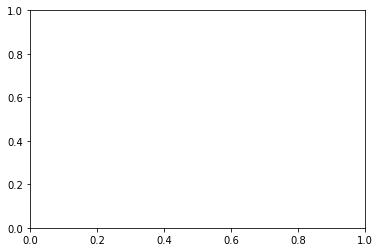

<IPython.core.display.Javascript object>

In [32]:
plt.plot(
    secop_2[["year_fecha_de_firma", "month_fecha_de_firma", "referencia_del_contrato"]]
    .groupby(["year_fecha_de_firma", "month_fecha_de_firma"])
    .count()
)

[<matplotlib.lines.Line2D object at 0x292778e50>]

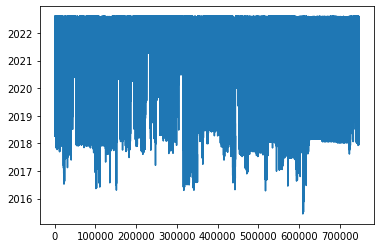

<IPython.core.display.Javascript object>

In [24]:
plt.plot(ºsecop_2["fecha_de_firma"])

In [13]:
secop_2[secop_2["estado_contrato"] == "borrador"]

,nombre_entidad,departamento,ciudad,orden,proceso_de_compra,referencia_del_contrato,estado_contrato,descripcion_del_proceso,modalidad_de_contratacion,fecha_de_firma,fecha_de_inicio_del_contrato,fecha_de_fin_del_contrato,tipodocproveedor,documento_proveedor,proveedor_adjudicado,valor_del_contrato,objeto_del_contrato,dias_adicionados,nit_entidad
10781,departamento de vichada,vichada,no definido,territorial,CO1.BDOS.701731,386,borrador,prestacion de servicios de apoyo a la gestion ...,contratacion directa,2019-01-30,2019-01-31,2019-06-30,cedula de ciudadania,1127389246,brigith alexandra arias dominguez,10000000,PRESTACION DE SERVICIOS DE APOYO A LA GESTION ...,0,800094067
10793,departamento de vichada,vichada,no definido,territorial,CO1.BDOS.682070,158,borrador,prestacion de servicios de un tecnologo en san...,contratacion directa,2019-01-22,2019-01-22,2019-06-28,cedula de ciudadania,1121911239,judith marcela nieto villamizar,12000000,PRESTACION DE SERVICIOS DE UN TECNOLOGO EN SAN...,0,800094067
10856,departamento de vichada,vichada,no definido,territorial,CO1.BDOS.683901,203,borrador,prestacion de servicios de apoyo a la gestion...,contratacion directa,2019-01-19,2019-01-21,2019-06-28,cedula de ciudadania,21249377,rafaela guayabo arrepiche,12000000,PRESTACION DE SERVICIOS DE APOYO A LA GESTION...,0,800094067
10878,departamento de vichada,vichada,no definido,territorial,CO1.BDOS.680630,132,borrador,prestación de servicios profesionales de una a...,contratacion directa,2019-01-19,2019-01-21,2019-06-30,cedula de ciudadania,1127383472,diana yesenia daza garcia,18600000,PRESTACIÓN DE SERVICIOS PROFESIONALES DE UNA A...,0,800094067
10891,departamento de vichada,vichada,no definido,territorial,CO1.BDOS.678152,068,borrador,prestación de servicios de apoyo a la gestión ...,contratacion directa,2019-01-18,2019-01-18,2019-06-30,cedula de ciudadania,30938186,sandra milena alvarez cardenas,12000000,PRESTACIÓN DE SERVICIOS DE APOYO A LA GESTIÓN ...,0,800094067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610968,agencia nacional de contratacion publica -colo...,distrito capital de bogota,bogota,nacional,CO1.BDOS.676099,CCE-826-4H-2019,borrador,asesorar a la subdirección de información y de...,contratacion directa,2019-01-17,2019-01-17,2019-12-31,cedula de ciudadania,24080618,claudia evelia lopez hernandez,159408327,Asesorar a la Subdirección de Información y De...,0,900514813
726139,metro de bogota sa,distrito capital de bogota,bogota,territorial,CO1.BDOS.724387,090 DE 2019,borrador,prestación de servicios profesionales para apo...,contratacion directa,2019-02-06,2019-02-08,2019-09-30,cedula de ciudadania,79381983,pedro oliverio avila romero,47792000,Prestación de servicios profesionales para apo...,0,901038962
726277,metro de bogota sa,distrito capital de bogota,bogota,territorial,CO1.BDOS.686117,014 DE 2019,borrador,la prestación de servicio de correo certificad...,contratacion directa,2019-01-25,2019-01-29,2019-12-31,nit,900062917,servicios postales nacionales s.a.s,12000000,La prestación de servicio de correo certificad...,0,901038962
726302,metro de bogota sa,distrito capital de bogota,bogota,territorial,CO1.BDOS.670616,012 de 2019 - rechazado,borrador,prestación de servicios profesionales a la emp...,contratacion directa,2019-01-22,2019-01-28,2019-07-27,nit,860029120,sociedad colombiana de arquitectos bogota d.c....,533752723,Prestación de servicios profesionales a la Emp...,0,901038962


<IPython.core.display.Javascript object>

In [12]:
secop_2["estado_contrato"].value_counts()

en ejecucion         254346
modificado           214352
activo               102322
terminado             77999
cerrado               28687
cedido                 6936
suspendido             1128
borrador                153
enviado proveedor        69
en aprobacion            41
prorrogado               32
Name: estado_contrato, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
secop_2.columns

Index(['nombre_entidad', 'departamento', 'ciudad', 'orden',
       'proceso_de_compra', 'referencia_del_contrato', 'estado_contrato',
       'descripcion_del_proceso', 'modalidad_de_contratacion',
       'fecha_de_firma', 'fecha_de_inicio_del_contrato',
       'fecha_de_fin_del_contrato', 'tipodocproveedor', 'documento_proveedor',
       'proveedor_adjudicado', 'valor_del_contrato', 'objeto_del_contrato',
       'dias_adicionados', 'nit_entidad'],
      dtype='object')

<IPython.core.display.Javascript object>

https://www.funcionpublica.gov.co/eva/gerentes/Modulo4/tema-2/1-modalidades.html

<a href="https://www.funcionpublica.gov.co/eva/gestornormativo/norma.php?i=304">Ley 80</a>